In [63]:
import pickle
import pandas as pd
pipeline = pickle.load(open('/Users/Yohann/code/YohannD/riiid-project/models/xgboost_pipe_M1.pkl', 'rb'))
qstats = pd.read_csv('/Users/Yohann/code/YohannD/riiid-project/data/qstats_for_M1')
pipeline_features_list=pd.read_csv('/Users/Yohann/code/YohannD/riiid-project/models/xgboost_pipe_M1_features_list')

In [61]:
def user_history_update(content_type_id,
                        content_id,
                        data_qstats,
                        user_history=None,
                        prior_question_had_explanation=False):
    '''Crée ou met à jour l'hisorique d'un utilisateur, stockée dans un df'''
    
    user_history_empty=pd.DataFrame({
                             #following columns are the impute of each loop
                             ### TO BE IMPUTED ###
                             'content_id':[-1],
                             'content_type_id':[-1],
                             'prior_question_had_explanation':False,
                             # following columns depend of previous history of the user : 
                             ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
                             'user_activity_cumcount':[-1],
                             'at_least_one_lesson':[0],
                             ### TO BE UPDATED IF LAST WAS QUESTION , ELSE COPIED ###
                             'user_avg_score_cum':[0.499],
                             'user_correct_answers_cum':[0],
                             'user_avg_score_cum_part1':[0.499],
                             'user_avg_score_cum_part2':[0.499],
                             'user_avg_score_cum_part3':[0.499],
                             'user_avg_score_cum_part4':[0.499],
                             'user_avg_score_cum_part5':[0.499],
                             'user_avg_score_cum_part6':[0.499],
                             'user_avg_score_cum_part7':[0.499],
                             'user_correct_answers_cum_part1':[0],
                             'user_correct_answers_cum_part2':[0],
                             'user_correct_answers_cum_part3':[0],
                             'user_correct_answers_cum_part4':[0],
                             'user_correct_answers_cum_part5':[0],
                             'user_correct_answers_cum_part6':[0],
                             'user_correct_answers_cum_part7':[0],
                             # following columns are pure question stats : 
                             ### TO BE IMPORTED ###
                             'part':[-1],
                             'qstats_answered_correctly':[-1],
                             'qstats_prior_question_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_had_explanation':[-1],
                             'qstats_answered_correctly_knowing_having_not_had_explanation':[-1],
                             # following columns depend of the current question AND the hisory of user
                             ### TO BE COMPUTED ###
                             'user_personalized_qstat_knowing_had_explanation_or_not':[-1],
                             'already_seen':[-1],
                             'user_avg_score_cum_on_this_part':[-1],
                             'user_correct_answers_cum_on_this_part':[-1],
                             # the following line is the prediction to be made
                             ### TO BE PREDICTED ###
                             'answered_correctly':[-1]
                          })
    
    if not type(user_history)==pd.DataFrame:
        user_history=user_history_empty
    
    last_line=user_history.iloc[-1]
    new_line =last_line.copy()
    
    last_content_type_id=user_history.iloc[-1]['content_type_id']
    
    ### TO BE IMPUTED ###
    new_line['content_id']=content_id
    new_line['content_type_id']=content_type_id
    new_line['prior_question_had_explanation']=prior_question_had_explanation
    ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
    new_line['user_activity_cumcount'] = last_line['user_activity_cumcount'] + 1
    new_line['at_least_one_lesson'] = last_line['at_least_one_lesson']

    if last_content_type_id==0:
        part=last_line['part']
        ### TO BE UPDATED IF LAST WAS QUESTION , ELSE COPIED ###
        new_line['user_correct_answers_cum'] = last_line['user_correct_answers_cum']\
                                             + last_line['answered_correctly']
        new_user_questions_count             = last_line['user_correct_answers_cum']\
                                             / last_line['user_avg_score_cum']\
                                             + 1
        new_line['user_avg_score_cum']       = new_line['user_correct_answers_cum']\
                                             / new_user_questions_count

        new_line[f'user_correct_answers_cum_part{part}'] = last_line[f'user_correct_answers_cum_part{part}']\
                                                         + last_line['answered_correctly']
        vars()[f'new_user_questions_count_part{part}']   = last_line[f'user_correct_answers_cum_part{part}']\
                                                         / last_line[f'user_avg_score_cum_part{part}']\
                                                         + 1
        new_line[f'user_avg_score_cum_part{part}']       = new_line[f'user_correct_answers_cum_part{part}']\
                                                         / vars()[f'new_user_questions_count_part{part}']                
        
    if content_type_id==0:        
        currect_question_stats=qstats.loc[qstats.content_id==content_id].iloc[-1]
        ### TO BE IMPORTED ###
        new_line['part']\
              = currect_question_stats['part']
        new_line['qstats_answered_correctly']\
              = currect_question_stats['qstats_answered_correctly']
        new_line['qstats_prior_question_had_explanation']\
              = currect_question_stats['qstats_prior_question_had_explanation']
        new_line['qstats_answered_correctly_knowing_having_had_explanation']\
              = currect_question_stats['qstats_answered_correctly_knowing_having_had_explanation']
        new_line['qstats_answered_correctly_knowing_having_not_had_explanation']\
              = currect_question_stats['qstats_answered_correctly_knowing_having_not_had_explanation']
        ### TO BE COMPUTED ###
        new_line['user_personalized_qstat_knowing_had_explanation_or_not']\
              = new_line['qstats_answered_correctly_knowing_having_had_explanation']\
             if prior_question_had_explanation\
           else new_line['qstats_answered_correctly_knowing_having_not_had_explanation']
        new_line['already_seen']\
              = 1 if content_id in user_history.loc[user_history.content_type_id==0,'content_id']\
           else 0
        new_line['user_avg_score_cum_on_this_part']=new_line[f'user_avg_score_cum_part{new_line["part"]}']
        new_line['user_correct_answers_cum_on_this_part']=new_line[f'user_correct_answers_cum_part{new_line["part"]}']
                                              
    elif content_type_id==1:
        ### TO BE UPDATED WHATEVER THE CONTENT_TYPE ###
        new_line['at_least_one_lesson']=1
        ### TO BE IMPORTED ###
        new_line['part']= -1 # TODO : si on veut utiliser la partie de la lecture, il faut importer la base des lectures
        new_line['qstats_answered_correctly']= -1
        new_line['qstats_prior_question_had_explanation']= -1
        new_line['qstats_answered_correctly_knowing_having_had_explanation']= -1
        new_line['qstats_answered_correctly_knowing_having_not_had_explanation']= -1
        ### TO BE COMPUTED ###
        new_line['user_personalized_qstat_knowing_had_explanation_or_not']= -1
        new_line['already_seen']= -1
        new_line['user_avg_score_cum_on_this_part']= -1
        new_line['user_correct_answers_cum_on_this_part']= -1
        
    ### TO BE PREDICTED ###
        user_history.iloc[-1,-1]\
        = my_pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]

    new_line['answered_correctly']= -1
                                
    user_history=user_history.append(new_line,ignore_index=True)

    return user_history

In [64]:
import random
user_history=None
for i in range(1000):
### CHOIX DE LA QUESTION ###
    next_question_id=random.choice(qstats.content_id.to_list())


    user_history=user_history_update(0,
                             next_question_id,
                             qstats,
                             user_history,
                             prior_question_had_explanation=random.uniform(0, 1)>0.1)
    ### PREDICTION ###
    user_history.iloc[-1,-1]\
    = pipeline.predict_proba(user_history[pipeline_features_list.feature.to_list()].iloc[-2:-1])[0,1]
    part = range(7)
user_history




,content_id,content_type_id,prior_question_had_explanation,user_activity_cumcount,at_least_one_lesson,user_avg_score_cum,user_correct_answers_cum,user_avg_score_cum_part1,user_avg_score_cum_part2,user_avg_score_cum_part3,...,part,qstats_answered_correctly,qstats_prior_question_had_explanation,qstats_answered_correctly_knowing_having_had_explanation,qstats_answered_correctly_knowing_having_not_had_explanation,user_personalized_qstat_knowing_had_explanation_or_not,already_seen,user_avg_score_cum_on_this_part,user_correct_answers_cum_on_this_part,answered_correctly
0,-1,-1,False,-1,0,0.499000,0.000000,0.499000,0.499000,0.49900,...,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1,-1.000000,-1.000000,-1.000000
1,8314,0,True,0,0,0.499000,0.000000,0.499000,0.499000,0.49900,...,5,0.720134,0.995302,0.720387,0.666667,0.720387,0,0.499000,0.000000,0.070943
2,2920,0,True,1,0,0.070943,0.070943,0.499000,0.499000,0.49900,...,4,0.780785,0.961927,0.780458,0.789062,0.780458,0,0.499000,0.000000,0.716298
3,1326,0,True,2,0,0.393620,0.787241,0.499000,0.499000,0.49900,...,2,0.705998,0.980512,0.708803,0.564841,0.708803,0,0.499000,0.000000,0.756137
4,8783,0,True,3,0,0.514459,1.543378,0.499000,0.756137,0.49900,...,5,0.853458,0.995701,0.852825,1.000000,0.852825,0,0.070943,0.070943,0.696429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,4293,0,True,995,0,0.793130,789.164830,0.783992,0.775243,0.82204,...,5,0.827644,0.961947,0.828389,0.808824,0.828389,0,0.791349,322.870343,0.830783
997,10890,0,True,996,0,0.793168,789.995612,0.783992,0.775243,0.82204,...,6,0.893446,0.967037,0.892588,0.918605,0.892588,0,0.754310,67.133558,0.942681
998,13419,0,True,997,0,0.793318,790.938293,0.783992,0.775243,0.82204,...,5,0.871795,0.997770,0.871508,1.000000,0.871508,0,0.791445,323.701125,0.968212
999,13342,0,True,998,0,0.793493,791.906506,0.783992,0.775243,0.82204,...,5,0.455157,0.997758,0.453933,1.000000,0.453933,0,0.791876,324.669338,0.960792


In [14]:
df_part = user_history[['part', 'user_avg_score_cum_part1','user_avg_score_cum_part2','user_avg_score_cum_part3',
                'user_avg_score_cum_part4', 'user_avg_score_cum_part5', 'user_avg_score_cum_part6', 'user_avg_score_cum_part7']]

In [65]:
df_part.to_csv('radar_chart.csv')

NameError: name 'df_part' is not defined

In [66]:
user_history.to_csv('user_history.csv')

In [ ]:
import numpy as np
categories = ['Part 1', 'Part 2', 'Part 3', 'Part 4', 'Part 5', 'Part 6', 'Part 7']

label_placement = np.linspace(start=0, stop=2+np.pi, num=len(x))
plt.figure(figsize=(6,6))
plt.subplot(polar=True)
plt.plot(label_placement, x)
lines, labels = plt.thetagrids(label_placement), labels=categories)

In [31]:
len(x)

8

KeyboardInterrupt: 

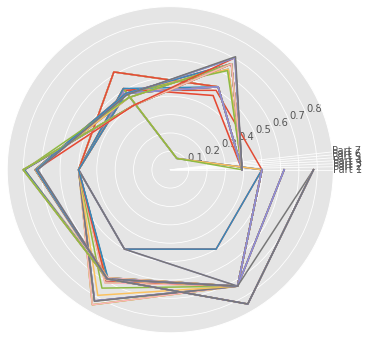

In [45]:
import time
categories = ['Part 1', 'Part 2', 'Part 3', 'Part 4', 'Part 5', 'Part 6', 'Part 7']
label_placement = np.linspace(start=0, stop=2*np.pi, num=7)
plt.figure(figsize=(6,6))
plt.subplot(polar=True)
lines, labels = plt.thetagrids((label_placement), labels=categories)



i = 1

while True:
    x=[]
    x= df_part.iloc[i, 1:].to_list()
    #x.append(df_part.iloc[i, 1:].to_list()[0])
    plt.plot(label_placement, x)
    i+=1
    time.sleep(0.1)


In [5]:
import matplotlib

def line_chart(days=days):
        chart_data = pd.DataFrame(
                np.random.randn(20, 3),
                columns=['a', 'b', 'c'])

        fig, ax = plt.subplots()

        max_x = 5
        max_rand = 10

        x = np.arange(0, max_x)
        ax.set_ylim(0, max_rand)
        line = ax.plot(x, np.random.randint(0, max_rand, max_x))

        def init():  # give a clean slate to start
            line.set_ydata([np.nan] * len(x))

        def animate(i):  # update the y values (every 1000ms)
            line.set_ydata(data['user']
            the_plot.pyplot(plt)

init()
for i range(5):
    

SyntaxError: invalid syntax (<ipython-input-5-7aa6cb7836c5>, line 24)

<IPython.core.display.Javascript object>


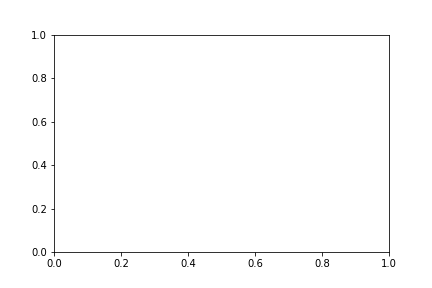

In [58]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time
import psutil
import sys

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

In [57]:
i=0
x=[]
y=[]


for i in range(5):
    x.append(i)
    y.append(psutil.cpu_percent())
    ax.plot(x,y, color='b')
    fig.canvas.draw()
    time.sleep(0.1)

In [44]:
x_i = [1, 2, 3, 4, 5]

In [54]:
y

[54.2,
 57.9,
 59.5,
 86.6,
 85.0,
 71.0,
 67.9,
 57.9,
 65.2,
 50.8,
 64.6,
 0.0,
 0.0,
 64.2,
 60.9,
 67.2,
 62.9,
 66.2,
 68.9,
 51.6,
 51.7,
 64.6,
 56.5,
 0.0,
 0.0,
 0.0,
 0.0,
 62.5,
 64.1,
 67.6,
 52.5,
 51.7,
 51.6,
 58.3,
 58.5,
 54.5,
 51.7,
 54.0,
 50.0,
 54.0,
 56.7,
 53.0,
 50.0,
 52.5,
 53.2,
 51.7,
 52.4,
 51.6,
 53.1,
 52.3]

In [67]:
pwd

'/Users/Yohann/code/YohannD/riiid-project/notebooks'

In [71]:
import chart_studio.plotly as py
from plotly.graph_objs import *

In [72]:
fig = py.get_figure("https://plotly.com/~ydoillon/2/")

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.Template: 'themeRef'

    Valid properties:
        data
            :class:`plotly.graph_objects.layout.template.Data`
            instance or dict with compatible properties
        layout
            :class:`plotly.graph_objects.Layout` instance or dict
            with compatible properties
        

In [75]:
py.sign_in('ydoillon', 'z1TCUMkdBwGVsYWZZ55f')


In [83]:
trace1 = {
  "meta": {"columnNames": {
      "x": "", 
      "y": "user_avg_score_cum"
    }}, 
  "mode": "lines", 
  "type": "scatter", 
  "ysrc": "ydoillon:1:2709e3", 
  "y": ["0.499", "0.499", "0.07094275165971296", "0.39362038444213104", "0.5144592049202515", "0.5599515290469901", "0.6031180078240835", "0.6058203513369179", "0.6188827507371825", "0.6177102966129339", "0.6020107457240337", "0.632108191615398", "0.6253191438459968", "0.6508389310536652", "0.6435768832327925", "0.6609292818650396", "0.6804707169815397", "0.669861191568343", "0.6797438101467216", "0.6840169868802047", "0.6874161517261499", "0.69115950726802", "0.6783947874568005", "0.6871300063958161", "0.6952860597798044", "0.693830188456947", "0.7010404410725848", "0.7056146761926689", "0.7080485969622649", "0.7116361311004873", "0.7115465216223646", "0.7079956897636892", "0.7046329593555455", "0.7019509077976794", "0.6899620166101285", "0.6910496063055145", "0.6913671322962913", "0.6928185107585798", "0.6850835276647201", "0.6859813539807088", "0.6919197591496105", "0.690710709856987", "0.6907008343179675", "0.6895686937773102", "0.6896728261747245", "0.6926083557238194", "0.6883935440207938", "0.6890078044862803", "0.6919535009206886", "0.6879745417065793", "0.6858808684058252", "0.6878240954967993", "0.690285271593364", "0.6904379487492738", "0.6914468523602028", "0.6870467646835097", "0.6889991727826549", "0.6916105381930697", "0.6945989679997603", "0.6950804996817428", "0.6950530664128921", "0.6969010071918627", "0.6980437826763417", "0.6996573699809815", "0.7043973858996777", "0.7036943116655624", "0.7055739039247982", "0.7043110283057133", "0.7002934948393519", "0.6999377686823584", "0.6988709949847587", "0.7016732933308687", "0.7010322705191285", "0.7045542885705909", "0.7052521197294787", "0.7061762017902482", "0.7029863180672603", "0.7061804980314853", "0.7046454864570593", "0.7038999918995826", "0.7052355647359276", "0.7017820192812899", "0.7001384499748058", "0.7034756335318778", "0.7059841761041896", "0.700794404331662", "0.6987798388964022", "0.7004554837628135", "0.699286964109778", "0.6985498811495201", "0.7003204457826528", "0.7029688240389652", "0.7052347206826626", "0.7073375781726079", "0.7081175571780775", "0.7097118422938599", "0.7092148442991937", "0.7107397049747519", "0.709579670071216", "0.7046733365682202", "0.7052167956671329", "0.706980433832853", "0.7062613920418876", "0.7078915180424169", "0.7061052513980022", "0.7076665003622687", "0.7101122027950127", "0.712837773869341", "0.7140261096565853", "0.710843582782565", "0.7128092312032721", "0.7109174340112292", "0.7126431499033794", "0.710947453635852", "0.7129372165038184", "0.7116258115037608", "0.7139372284815232", "0.7162216879247181", "0.7166165480201386", "0.7175211604313556", "0.7184238737924299", "0.7192401360707814", "0.7198848236932032", "0.7214276913044173", "0.7218579979659837", "0.7208411758183102", "0.7209635665836103", "0.7223560153174777", "0.7218976390953871", "0.7235714451662503", "0.7243184305886511", "0.7246150317697985", "0.7251132161289906", "0.725273648995987", "0.724491559866423", "0.722863121712301", "0.7243421944837688", "0.724379075902515", "0.7206324333560444", "0.7222659725502462", "0.7239174490165323", "0.7216648955852942", "0.7234316553168985", "0.7228897747003102", "0.7238341761041043", "0.7217823546579518", "0.7224848566619031", "0.7213673539451843", "0.7226549178582153", "0.7221482724525362", "0.7185586207464363", "0.719243288587659", "0.7207835043129727", "0.7196191263452274", "0.721228661819698", "0.7228465930148033", "0.72437937596963", "0.725491426893166", "0.723406362260393", "0.7232867795024639", "0.7239353666232586", "0.7254247134283411", "0.7249768883597308", "0.7244432057503918", "0.724861115320719", "0.7255015024608465", "0.7256306751993451", "0.7268323620251723", "0.7263758045015493", "0.7264933177991356", "0.7274965598552506", "0.728660749901179", "0.729977014609802", "0.7290422835454304", "0.7281814786302038", "0.7273471548674276", "0.726918327670794", "0.7280236316900134", "0.72900074464254", "0.7291755257690845", "0.7304738560524392", "0.7313925302968542", "0.7286133462717702", "0.7275076265353058", "0.7280924217354161", "0.7279874022197713", "0.7293025860074923", "0.7277867454999106", "0.7285791361653813", "0.7289882382569087", "0.7290758184213347", "0.7301087850833002", "0.7310732618108432", "0.730713470615325", "0.7316635377105158", "0.7280136609209668", "0.7270990534108727", "0.7274195634343239", "0.72642415186389", "0.7271460862259151", "0.7265734987971452", "0.7274299439214156", "0.727944536448495", "0.7284581308178968", "0.7284250968871914", "0.7296700957612878", "0.728503060617347", "0.7292921584312142", "0.7284877690288105", "0.7283111796115956", "0.7293637048560186", "0.729888054107577", "0.7311125216398343", "0.732039410476373", "0.7331179568303005", "0.7339109701415185", "0.7342143179214431", "0.7322001719370242", "0.7324755544503365", "0.7328382291826502", "0.7337815186509159", "0.7338583209797138", "0.7348245192592981", "0.7351616418193508", "0.7362496022617618", "0.7362526586985728", "0.7367039851405035", "0.7361453358024026", "0.7340176435505421", "0.7335287502210469", "0.7346883599745605", "0.7347928274880821", "0.735238750780917", "0.7357038178078741", "0.734574652987862", "0.7338592389320798", "0.7346776381368716", "0.735297777438339", "0.7355368508555856", "0.7363695178270411", "0.7365861758881771", "0.7369633036247577", "0.7376514004726994", "0.7369115773089987", "0.7359673144233297", "0.7359275650163027", "0.7366206444097531", "0.73694360593473", "0.7373501986553369", "0.7378799323393953", "0.7384051585165812", "0.7391375121455146", "0.7400547514259341", "0.7409270647796878", "0.7411993585836018", "0.7404714904914236", "0.740782822064688", "0.7404034412059172", "0.7400525741236287", "0.7395172083600171", "0.7381439343208597", "0.7386670228065864", "0.7392894275667826", "0.7395953932432228", "0.7402127216742347", "0.7404539538086424", "0.7403245960150353", "0.7408581765672135", "0.7410557288219993", "0.7415659990343226", "0.7414554666428157", "0.741499713108193", "0.7418486615002743", "0.7425709186740855", "0.7429380983119133", "0.7427320139585244", "0.7433405768719094", "0.7435226930013409", "0.7433306420695487", "0.7415681429917985", "0.7422536881914925", "0.7424053855305036", "0.7425601186699754", "0.7426048587831108", "0.7419081583385954", "0.7426303067484084", "0.7430929903586907", "0.7433177485592292", "0.7429980094462738", "0.742149039568607", "0.7426879669782318", "0.7432287466075521", "0.7434673618096695", "0.7437298195665758", "0.7434994436293058", "0.7436061265110424", "0.7435912417856863", "0.7421661869747912", "0.7425233832133458", "0.7429313015260164", "0.7429725857081726", "0.7431378646646727", "0.7433667370090142", "0.7440062814131064", "0.7445935004692057", "0.7448988155530704", "0.7438633287150309", "0.7441811357793675", "0.7440661704512771", "0.7424572666645471", "0.7409904297281951", "0.7415798907288537", "0.74222743994857", "0.7424272279819631", "0.7430839823772067", "0.743655738309181", "0.744089066768543", "0.7434466412967661", "0.7424904606325667", "0.7430368634054124", "0.7434748007537322", "0.7442717507459278", "0.7439535947650486", "0.7441476222930431", "0.7447217654782892", "0.7442834564006527", "0.7445039131218559", "0.7452108577485709", "0.7458321667317721", "0.7458472005551503", "0.7454438926940194", "0.7455135885254435", "0.7458155494861203", "0.7461590133411865", "0.7468478042894088", "0.7462551349019823", "0.7469777326038276", "0.7467831272063454", "0.7472658949226324", "0.7467343989036809", "0.7473724405752954", "0.7479193700177043", "0.7485991080883054", "0.748187707311847", "0.7485923806894373", "0.7477838281438828", "0.7475307596563076", "0.7476809249801566", "0.7479609550620073", "0.7481797153950213", "0.7484567115210595", "0.7485249902506419", "0.7489376440783976", "0.7495449109719599", "0.7496273648810593", "0.7499585632518939", "0.750515046732475", "0.7504416139604994", "0.7510895708964811", "0.7515388002283456", "0.7512896703041744", "0.7517268923780132", "0.7521454702957266", "0.7523521146084223", "0.7527380970796869", "0.7532945873336155", "0.7537632530904262", "0.7539444899213337", "0.7542098077323031", "0.7543251468125355", "0.7533895437837291", "0.7539677260643706", "0.7535357948011029", "0.7525395996048069", "0.7529118927720937", "0.7532995212693874", "0.753863275745578", "0.7543295696658375", "0.7545800148444095", "0.7547861319450673", "0.7553552425266786", "0.7555252120523457", "0.7556765262585887", "0.7561464475301541", "0.7562806079579539", "0.7564780673169212", "0.7566118873625995", "0.7571816311239684", "0.7577498852505833", "0.7579604388498951", "0.7570147840941904", "0.7574464980001723", "0.756875809632054", "0.7561843450713132", "0.7560023298542325", "0.7552168631666156", "0.7556889249919315", "0.7561630382021732", "0.7551834215666122", "0.7549451912939753", "0.7547033794138112", "0.7544022180619113", "0.7543527664468339", "0.7545929134970616", "0.7536702896040434", "0.753854611177919", "0.754275766011058", "0.7548172730454016", "0.7552716413441859", "0.7552487191257", "0.7555649015535171", "0.7553141970674081", "0.7557381388515745", "0.7560918633333783", "0.7565824218656834", "0.7563743017182168", "0.7561877586564529", "0.7566032965918892", "0.7569349574692624", "0.7571459374698866", "0.7570797185736619", "0.7572282470839572", "0.7576122101465191", "0.7567056970086874", "0.7558118858454811", "0.7557122245394368", "0.7562162486962787", "0.7567113970401919", "0.7568866459159528", "0.7571594911591649", "0.7574703406467536", "0.7576964873457537", "0.7578997900747635", "0.7578136219057823", "0.7572650447833007", "0.7577311741199254", "0.7581519334854331", "0.7584076492657763", "0.7589102536703998", "0.7587972446726552", "0.7587504657460965", "0.7590914252281977", "0.7587309618252959", "0.7590443103116196", "0.759461539661718", "0.7595263834117573", "0.7598275031072289", "0.7599681347761389", "0.7602765597042941", "0.7599190831526069", "0.7604008861197014", "0.7604890531670171", "0.7609292980787181", "0.7606092980849787", "0.7603518741534322", "0.7605760270906289", "0.7599986324346676", "0.7604138818552023", "0.760769607610283", "0.7612534800127275", "0.7613315543492097", "0.7617923211194698", "0.7619670666301087", "0.761850228410235", "0.7613634002308459", "0.7618337981590807", "0.7618184796796956", "0.7620996407269542", "0.7624866803017948", "0.7628882800942809", "0.7632771356888535", "0.7634908756698495", "0.7636682161591054", "0.763997762646921", "0.7636659169353468", "0.7636318697768432", "0.7640113330244819", "0.7644618176498935", "0.7643139254090208", "0.7643775238217553", "0.7647758264179287", "0.7650913565263416", "0.7654420097309709", "0.765505387591663", "0.7658587406361081", "0.7661988971501406", "0.7663290327680141", "0.7663248727442084", "0.7663431961033625", "0.7655067116027013", "0.7657139602739865", "0.7657731439605623", "0.7658855015239813", "0.7662234818831276", "0.7662500834316615", "0.7660198610952939", "0.76644977347937", "0.7667639372369371", "0.7665629179491686", "0.766837357756007", "0.7671454419936616", "0.7674657956767216", "0.767858360798067", "0.7679890243182691", "0.7677808865162807", "0.7680985235948992", "0.7681964143486214", "0.768078047123896", "0.7681622219811913", "0.768478106780617", "0.768837873284795", "0.7691558462207514", "0.7694674811512762", "0.7694808898279373", "0.7697054709186275", "0.7696528151544904", "0.7700497025995415", "0.7702376881677707", "0.7703737765343286", "0.7707706426930312", "0.7705815174761209", "0.7707710396103751", "0.7707985274857176", "0.7707389604551586", "0.770446945707256", "0.7706002785055722", "0.7708914514108953", "0.7711140540787398", "0.7708674194470678", "0.7712173955761868", "0.771571417491429", "0.7718800143550403", "0.7723068265459835", "0.7724858089747555", "0.7725393721521733", "0.7729315632061255", "0.7730442444657694", "0.7731209706509623", "0.772730118480484", "0.7729950644235418", "0.7732295107660241", "0.7732544032357754", "0.7734404916754378", "0.7738117881581371", "0.7741591967328869", "0.7741073346304702", "0.7741760093904908", "0.7743654359788793", "0.774499512912708", "0.7746402591582064", "0.7747785392166997", "0.7750540393080608", "0.7753497714587284", "0.775200422915817", "0.775538805490124", "0.7757703604743663", "0.7759374358418919", "0.7763062821817701", "0.7764287154507714", "0.7763420963501182", "0.7765627874625272", "0.7759658749459766", "0.7763189642789879", "0.7757571596488487", "0.7757341796678702", "0.7748428178509376", "0.7744822161531232", "0.7747508572182891", "0.7748221084618484", "0.7749571600420563", "0.774938516054106", "0.7747208349485147", "0.7747834220611182", "0.7747447398818725", "0.7749163044086782", "0.7750494212393684", "0.775381521275381", "0.7754238290518575", "0.775631326898528", "0.7756117795022683", "0.7752005773002374", "0.775403647546701", "0.7757375289392987", "0.7758421892805611", "0.7761061282227697", "0.7763622011085455", "0.7767177237826622", "0.7767460475176444", "0.77705809451989", "0.7768534252242781", "0.7770112237879763", "0.7767755768466161", "0.7769580953323456", "0.7770873937079108", "0.7773276476983504", "0.7776376852340883", "0.7772381711595029", "0.7772139786413795", "0.7771509015582859", "0.7772424572362551", "0.777306343722461", "0.7773557080923935", "0.777437271581598", "0.7771024558179392", "0.7771314262008158", "0.7771480024298025", "0.7774728486259427", "0.7772595366167326", "0.7773115920941623", "0.7775144675889825", "0.7776640681957447", "0.7779975494764956", "0.7774008850367803", "0.7774788305544048", "0.7775704582535007", "0.777810837582971", "0.7778898042943877", "0.7779369392966404", "0.778141816620743", "0.778410233038679", "0.7785288141213944", "0.7784762615389699", "0.777807189368242", "0.7781103089296904", "0.7783433727485564", "0.7784832437718925", "0.7785930913750089", "0.7788067660336344", "0.7786812888665825", "0.777826110948793", "0.7772471475935798", "0.77742193337527", "0.7776486911656961", "0.7777635166714985", "0.7778560359206358", "0.7777405366543299", "0.7771305035829184", "0.7771064368793695", "0.7770078209765922", "0.777154174314554", "0.7773566866658403", "0.7776408633643968", "0.7779593793610914", "0.778160644080663", "0.7783527924908232", "0.7785703761041486", "0.7786603805250443", "0.7789062060891717", "0.779079655929989", "0.7794188478795782", "0.779310573186631", "0.7795578408998838", "0.7798082145019032", "0.7801092230829063", "0.7796136221523134", "0.7796874289731903", "0.7799865535494926", "0.780217046110728", "0.7805474145383857", "0.7806809658877977", "0.7807871263824055", "0.7810683164716451", "0.7812418387590299", "0.7813037995203351", "0.7815829379603957", "0.7810242784908356", "0.7811717307051614", "0.7813292063208553", "0.7815637192613625", "0.7817821912614414", "0.7818488023357745", "0.7820042510427849", "0.7820211287092433", "0.7823092133785023", "0.7826045750962962", "0.7818907215275351", "0.7818085179612683", "0.7819144799840535", "0.7819178064904724", "0.781896599037958", "0.7819972585632468", "0.7822087850529563", "0.7822371337880116", "0.7821636736843164", "0.7823194424433628", "0.782097355786723", "0.7823328818422172", "0.7821830742446395", "0.7820103765893217", "0.781790030357799", "0.7818638768455459", "0.7817156174151958", "0.7819110137419856", "0.7820834378487399", "0.7816670972725631", "0.7816138242522664", "0.7811831880089309", "0.7813088185580604", "0.7815553481539397", "0.7818193093271585", "0.7818944180406797", "0.7819946561885762", "0.7821718444266139", "0.7823273706846046", "0.7818086730931754", "0.7817761140130233", "0.7820109738256645", "0.7821102925420083", "0.7820832316224353", "0.782189061433445", "0.7822836418819549", "0.7822295188012949", "0.7825103596344233", "0.7826739952376487", "0.7828266529678071", "0.7829736762118787", "0.7831646535630832", "0.7832343510998776", "0.7832190677194728", "0.7833161445907512", "0.783183444937315", "0.7833401146619198", "0.7826395450693003", "0.7826694149079327", "0.7820992661317628", "0.7821334606469688", "0.7822011002380199", "0.7821822555076768", "0.7822370551086596", "0.7822907340547939", "0.782518250633434", "0.7821964783201688", "0.7820341572623317", "0.7820138288968582", "0.7821426521836037", "0.7819816816747713", "0.7821083809037336", "0.7820251509606464", "0.7819765147074177", "0.7817626243773704", "0.781858859520849", "0.7818714218995165", "0.7818073839121935", "0.78163095024259", "0.7817848757100916", "0.7819523847302646", "0.781752844284055", "0.7817787685756199", "0.7818746240612506", "0.781965427708538", "0.7820817423642702", "0.7822796267297029", "0.7820932693855679", "0.7823013499165873", "0.7824735965290642", "0.7827373881816869", "0.7824681406625351", "0.7822941002662439", "0.7824511408461499", "0.7826451329063926", "0.7829062278604252", "0.7829432734695776", "0.7831813366477112", "0.783150349460495", "0.7834044468103262", "0.7835637994157029", "0.7835589470915396", "0.783530464721683", "0.7836025991058188", "0.7836984051083148", "0.7839245153395648", "0.7841227019011267", "0.7839499015109389", "0.7839870916443845", "0.7838164228359018", "0.7838754486727402", "0.7839359337415074", "0.7837895395665025", "0.7840279000446425", "0.7840767913468464", "0.7837185872569079", "0.7837582645127187", "0.7839966533673702", "0.783738208833105", "0.7836263753411292", "0.7837877541368208", "0.7839682123468574", "0.7841290008632794", "0.7843605274468872", "0.7844537366756055", "0.7845451775125891", "0.7846653967290909", "0.7847950342835037", "0.7850655347832028", "0.78529340462807", "0.785491831469269", "0.7853633332092661", "0.7853102103686005", "0.7855612881607738", "0.7857827878406991", "0.7859683076933504", "0.7861501713424176", "0.7863395261718747", "0.786059797427791", "0.7861268508812989", "0.7862733785533205", "0.7865130704784362", "0.7867380537234386", "0.7867258038081653", "0.7867801989982283", "0.7870007001179267", "0.7870914960291774", "0.7868487299255169", "0.7869997221766605", "0.7871854630487285", "0.7869155512748754", "0.7867420398158752", "0.7866914037778702", "0.7861641716962136", "0.7861864171181754", "0.7863606501757728", "0.7863309723724466", "0.78648523975218", "0.7865713399386758", "0.7866959057782141", "0.7865419006248004", "0.7866430532287175", "0.786709806873944", "0.7868922356387158", "0.7868796896846473", "0.7869975346982144", "0.787100170547927", "0.7872180451729128", "0.7873844777393222", "0.7874791592342518", "0.7876234556504734", "0.7877187432067224", "0.7879151862000506", "0.7880513736286572", "0.7882571342682605", "0.7883062976664569", "0.7882374988476695", "0.7883349068204424", "0.7885084907299175", "0.7885618861633862", "0.7887956430460621", "0.7890303968428384", "0.7891944996350472", "0.7891673948502724", "0.7888034449481726", "0.788942494628536", "0.7889168660537864", "0.7891080390991279", "0.7889452594166214", "0.7890246367412512", "0.7890291015301372", "0.7890527023307955", "0.7892972879057548", "0.789433783075887", "0.7896204310936641", "0.7898167036854143", "0.7900100238644219", "0.7900183704405925", "0.7897844927628753", "0.7894596623999711", "0.7895529647811574", "0.7897124800623911", "0.7898904768765945", "0.7900060194225267", "0.7897998467011451", "0.7900094948275298", "0.7901393640386976", "0.7902502700819651", "0.7902322440661731", "0.7902774644845166", "0.7897012718148763", "0.7899153749923787", "0.7896185822971197", "0.7895114789160286", "0.789553130614215", "0.7895138181920489", "0.789679028552922", "0.7898435365376089", "0.7898178162083046", "0.7898788369952074", "0.7900720405600926", "0.7902906106346246", "0.7904585354339713", "0.7902792353958019", "0.7900548238332407", "0.7898507401020265", "0.7899640783009092", "0.7900504109341401", "0.7902487033342274", "0.7901974187454422", "0.7903602152209148", "0.7902447749920153", "0.790376697249737", "0.7895452658176603", "0.789443107874424", "0.7894082893923817", "0.7893783578662621", "0.7895538290940964", "0.7897098602192201", "0.7897201815887845", "0.7898490203494786", "0.7900370842043113", "0.7902286800599229", "0.790180120225936", "0.790260973386988", "0.790298782606361", "0.7901104785694691", "0.7903178227377472", "0.7905460699127557", "0.7907303831446606", "0.7907952201051887", "0.7908494753684545", "0.7907479010861652", "0.7909115097948201", "0.7911025578285548", "0.791302430249985", "0.7911322146495241", "0.7906789306848957", "0.790855138493433", "0.7910788803879029", "0.7912107044136046", "0.7909638654662375", "0.7907182120858719", "0.7907921229873417", "0.7907475846500962", "0.7907037786567869", "0.7905617821946329", "0.7906935768291327", "0.7907476194665571", "0.7907818057996869", "0.7909411627098476", "0.7910750293959082", "0.79118543162831", "0.7913570002529745", "0.7915472144262192", "0.7910963722670926", "0.7911982060404507", "0.7913731831658178", "0.791140012085794", "0.7912350437384061", "0.7908222798583693", "0.7902541154942645", "0.7904420189608745", "0.7906501186950149", "0.7904098597914327", "0.7904352867837736", "0.7905928211111122", "0.7908120805545799", "0.7909951841602264", "0.7909929538547379", "0.7910335374138839", "0.7911052631275397", "0.7911380487106231", "0.7911951057670955", "0.7913714105688786", "0.7912920927720158", "0.7913884542105765", "0.7912353278031651", "0.791362697854925", "0.791303571575965", "0.7914619213457892", "0.7915928142584805", "0.7917855650611727", "0.7918754934449553", "0.7919997591299235", "0.7921990283571514", "0.7919670745247752", "0.792033345084554", "0.7921787144533669", "0.7922620825728698", "0.7924617322482017", "0.792127943193692", "0.7922767728563838", "0.7922158860096972", "0.7921335287203769", "0.7921855268460198", "0.7922540611811043", "0.7922070997636249", "0.7921981726803423", "0.7923081903449369", "0.7923270254236742", "0.7923122804597561", "0.7924585180519259", "0.7922302964641856", "0.7922676654538129", "0.7924164982440732", "0.7925256193360367", "0.7927025624737852", "0.7927248319338521", "0.7928568762570307", "0.7930536694641266", "0.7931304823581067", "0.7931682856156611", "0.7933182481668393", "0.7934934926541395", "0.7936609586066613"], 
  "error_x": {
    "type": "percent", 
    "color": "#636efa", 
    "value": 10, 
    "width": 4, 
    "visible": False, 
    "symmetric": True, 
    "thickness": 2
  }
}


data = Data([trace1])


layout = {
  "font": {
    "size": 16, 
    "family": "Balto"
  }, 
  "title": {"text": "Mic Patterns"}, 
  "xaxis": {
    "range": [0, 1000], 
    "title": {"text": "Number of questions answered"}, 
    "autorange": True, 
    "gridwidth": 3, 
    "zerolinewidth": 1
  }, 
  "yaxis": {
    "type": "linear", 
    "range": [0.03079174016266028, 0.833811970103714], 
    "title": {"text": "Average score"}, 
    "autorange": True
  }, 
  "modebar": {"orientation": "h"}, 
  "autosize": True, 
  "template": {
    "data": {
      "bar": [
        {
          "type": "bar", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "table": [
        {
          "type": "table", 
          "cells": {
            "fill": {"color": "#EBF0F8"}, 
            "line": {"color": "white"}
          }, 
          "header": {
            "fill": {"color": "#C8D4E3"}, 
            "line": {"color": "white"}
          }
        }
      ], 
      "carpet": [
        {
          "type": "carpet", 
          "aaxis": {
            "gridcolor": "#C8D4E3", 
            "linecolor": "#C8D4E3", 
            "endlinecolor": "#2a3f5f", 
            "minorgridcolor": "#C8D4E3", 
            "startlinecolor": "#2a3f5f"
          }, 
          "baxis": {
            "gridcolor": "#C8D4E3", 
            "linecolor": "#C8D4E3", 
            "endlinecolor": "#2a3f5f", 
            "minorgridcolor": "#C8D4E3", 
            "startlinecolor": "#2a3f5f"
          }
        }
      ], 
      "mesh3d": [
        {
          "type": "mesh3d", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }
        }
      ], 
      "contour": [
        {
          "type": "contour", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }, 
          "autocolorscale": True
        }
      ], 
      "heatmap": [
        {
          "type": "heatmap", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }, 
          "autocolorscale": True
        }
      ], 
      "scatter": [
        {
          "type": "scatter", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "surface": [
        {
          "type": "surface", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }
        }
      ], 
      "heatmapgl": [
        {
          "type": "heatmapgl", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }
        }
      ], 
      "histogram": [
        {
          "type": "histogram", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "parcoords": [
        {
          "line": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}, 
          "type": "parcoords"
        }
      ], 
      "scatter3d": [
        {
          "type": "scatter3d", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "scattergl": [
        {
          "type": "scattergl", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "choropleth": [
        {
          "type": "choropleth", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }
        }
      ], 
      "scattergeo": [
        {
          "type": "scattergeo", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "histogram2d": [
        {
          "type": "histogram2d", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }, 
          "autocolorscale": True
        }
      ], 
      "scatterpolar": [
        {
          "type": "scatterpolar", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "contourcarpet": [
        {
          "type": "contourcarpet", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }
        }
      ], 
      "scattercarpet": [
        {
          "type": "scattercarpet", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "scattermapbox": [
        {
          "type": "scattermapbox", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "scatterpolargl": [
        {
          "type": "scatterpolargl", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "scatterternary": [
        {
          "type": "scatterternary", 
          "marker": {"colorbar": {
              "ticks": "", 
              "outlinewidth": 0
            }}
        }
      ], 
      "histogram2dcontour": [
        {
          "type": "histogram2dcontour", 
          "colorbar": {
            "ticks": "", 
            "outlinewidth": 0
          }, 
          "autocolorscale": True
        }
      ]
    }, 
    "layout": {
      "geo": {
        "bgcolor": "white", 
        "showland": True, 
        "lakecolor": "white", 
        "landcolor": "white", 
        "showlakes": True, 
        "subunitcolor": "#C8D4E3"
      }, 
      "font": {"color": "#2a3f5f"}, 
      "polar": {
        "bgcolor": "white", 
        "radialaxis": {
          "ticks": "", 
          "gridcolor": "#EBF0F8", 
          "linecolor": "#EBF0F8"
        }, 
        "angularaxis": {
          "ticks": "", 
          "gridcolor": "#EBF0F8", 
          "linecolor": "#EBF0F8"
        }
      }, 
      "scene": {
        "xaxis": {
          "ticks": "", 
          "gridcolor": "#DFE8F3", 
          "gridwidth": 2, 
          "linecolor": "#EBF0F8", 
          "zerolinecolor": "#EBF0F8", 
          "showbackground": True, 
          "backgroundcolor": "white"
        }, 
        "yaxis": {
          "ticks": "", 
          "gridcolor": "#DFE8F3", 
          "gridwidth": 2, 
          "linecolor": "#EBF0F8", 
          "zerolinecolor": "#EBF0F8", 
          "showbackground": True, 
          "backgroundcolor": "white"
        }, 
        "zaxis": {
          "ticks": "", 
          "gridcolor": "#DFE8F3", 
          "gridwidth": 2, 
          "linecolor": "#EBF0F8", 
          "zerolinecolor": "#EBF0F8", 
          "showbackground": True, 
          "backgroundcolor": "white"
        }
      }, 
      "title": {"x": 0.05}, 
      "xaxis": {
        "ticks": "", 
        "gridcolor": "#EBF0F8", 
        "linecolor": "#EBF0F8", 
        "automargin": True, 
        "zerolinecolor": "#EBF0F8", 
        "zerolinewidth": 2
      }, 
      "yaxis": {
        "ticks": "", 
        "gridcolor": "#EBF0F8", 
        "linecolor": "#EBF0F8", 
        "automargin": True, 
        "zerolinecolor": "#EBF0F8", 
        "zerolinewidth": 2
      }, 
      "ternary": {
        "aaxis": {
          "ticks": "", 
          "gridcolor": "#DFE8F3", 
          "linecolor": "#A2B1C6"
        }, 
        "baxis": {
          "ticks": "", 
          "gridcolor": "#DFE8F3", 
          "linecolor": "#A2B1C6"
        }, 
        "caxis": {
          "ticks": "", 
          "gridcolor": "#DFE8F3", 
          "linecolor": "#A2B1C6"
        }, 
        "bgcolor": "white"
      }, 
      "colorway": ["#636efa", "#EF553B", "#00cc96", "#ab63fa", "#19d3f3", "#e763fa", "#fecb52", "#ffa15a", "#ff6692", "#b6e880"], 
      "hovermode": "closest", 
      "colorscale": {
        "diverging": [
          [0, "#8e0152"], [0.1, "#c51b7d"], [0.2, "#de77ae"], [0.3, "#f1b6da"], [0.4, "#fde0ef"], [0.5, "#f7f7f7"], [0.6, "#e6f5d0"], [0.7, "#b8e186"], [0.8, "#7fbc41"], [0.9, "#4d9221"], [1, "#276419"]
        ], 
        "sequential": [
          [0, "#0508b8"], [0.0893854748603352, "#1910d8"], [0.1787709497206704, "#3c19f0"], [0.2681564245810056, "#6b1cfb"], [0.3575418994413408, "#981cfd"], [0.44692737430167595, "#bf1cfd"], [0.5363128491620112, "#dd2bfd"], [0.6256983240223464, "#f246fe"], [0.7150837988826816, "#fc67fd"], [0.8044692737430168, "#fe88fc"], [0.8938547486033519, "#fea5fd"], [0.9832402234636871, "#febefe"], [1, "#fec3fe"]], 
        "sequentialminus": [
          [0, "#0508b8"], [0.0893854748603352, "#1910d8"], [0.1787709497206704, "#3c19f0"], [0.2681564245810056, "#6b1cfb"], [0.3575418994413408, "#981cfd"], [0.44692737430167595, "#bf1cfd"], [0.5363128491620112, "#dd2bfd"], [0.6256983240223464, "#f246fe"], [0.7150837988826816, "#fc67fd"], [0.8044692737430168, "#fe88fc"], [0.8938547486033519, "#fea5fd"], [0.9832402234636871, "#febefe"], [1, "#fec3fe"]]
      }, 
      "plot_bgcolor": "white", 
      "paper_bgcolor": "white", 
      "shapedefaults": {
        "line": {"width": 0}, 
        "opacity": 0.4, 
        "fillcolor": "#506784"
      }, 
      "annotationdefaults": {
        "arrowhead": 0, 
        "arrowcolor": "#506784", 
        "arrowwidth": 1
    }
    }, 
  }
}
        
        
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)


In [79]:
py.get_figure("https://plotly.com/~ydoillon/2/")

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.Template: 'themeRef'

    Valid properties:
        data
            :class:`plotly.graph_objects.layout.template.Data`
            instance or dict with compatible properties
        layout
            :class:`plotly.graph_objects.Layout` instance or dict
            with compatible properties
        

In [85]:
py.plot(Data([Scatter(x=[1, 2], y=[2, 3])]), filename ="Plot 6", fileopt="extend")

/Users/Yohann/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




'https://plotly.com/~ydoillon/6/'